<h1><center>Robustness - HDFS</center></h1>

In [327]:
from loglizer.models import *
from loglizer import dataloader, preprocessing, utils
from imblearn.over_sampling import SMOTE, RandomOverSampler
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from matplotlib.lines import Line2D
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef, roc_auc_score, confusion_matrix

start = time.time()

supervised = ['LR', 'SVM', 'DecisionTree']
unsupervised = ['PCA', 'IsolationForest', 'InvariantsMiner']
semi_supervised = ['LogClustering']

#Load data
label_file = 'data/HDFS/anomaly_label.csv'
path = '../../../loglizer/HDFS_Data/'

#dfs = []
for train_ratio in [0.5, 0.75, 0.9]:
    for reduction_train in [0.0, 0.25, 0.5, 0.75, 0.99, 0.999]:
        print('Training ratio', train_ratio, '- Reduction percentage', reduction_train)
        #Load training data
        data_train = np.load(path + 'train/' + str(train_ratio) + '/'+ str(reduction_train) +'/HDFS_train_' + str(train_ratio) + '_' + str(reduction_train) +  '.npz', allow_pickle=True)
        x_tr, y_train = data_train['x_data'], data_train['y_data']

        #Shuffle
        indexes_train = shuffle(np.arange(len(x_tr)))
        x_tr, y_train = x_tr[indexes_train], y_train[indexes_train]

        for reduction_test in [0.0, 0.25, 0.5, 0.75, 0.99, 0.999]:
            print('Reduction percentage', reduction_test)

            #Load test data
            data_test = np.load(path + 'test/' + str(train_ratio) + '/'+ str(reduction_test) +'/HDFS_test_' + str(train_ratio) + '_' + str(reduction_test) + '.npz', allow_pickle=True)
            x_te, y_test = data_test['x_data'], data_test['y_data']

            #Shuffle
            indexes_test = shuffle(np.arange(len(x_te)))
            x_te, y_test = x_te[indexes_test], y_test[indexes_test]

            for _model in supervised + unsupervised + semi_supervised:
                print('-'*30,'CURRENTLY:', _model,'-'*30)
                #If model is supervised, generate new samples by randomly sampling with replacement the current available samples to balance both classes.

                if(_model in supervised):
                    feature_extractor = preprocessing.FeatureExtractor()
                    x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf')

                    #Oversample anomalies
                    sm = RandomOverSampler(random_state=2)
                    x_train_sm, y_train_sm = sm.fit_sample(x_train, y_train)

                    if(_model == 'SVM'):
                        model = SVM()
                    elif(_model == 'DecisionTree'):
                        model = DecisionTree()
                    else:
                        model = LR()
                    model.fit(x_train_sm, y_train_sm)

                else:
                    if _model == 'PCA':
                        feature_extractor = preprocessing.FeatureExtractor()
                        x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf', 
                                                                  normalization='zero-mean')
                        model = PCA()
                        model.fit(x_train)

                    elif _model == 'InvariantsMiner':
                        feature_extractor = preprocessing.FeatureExtractor()
                        x_train = feature_extractor.fit_transform(x_tr)
                        #model = InvariantsMiner(epsilon=0.5)
                        model = InvariantsMiner(epsilon=0.001)
                        model.fit(x_train)

                    elif _model == 'LogClustering':
                        feature_extractor = preprocessing.FeatureExtractor()
                        x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf')
                        model = LogClustering(max_dist=0.3, anomaly_threshold=0.3)
                        model.fit(x_train[y_train == 0, :]) # Use only normal samples for training

                    elif _model == 'IsolationForest':
                        feature_extractor = preprocessing.FeatureExtractor()
                        x_train = feature_extractor.fit_transform(x_tr)
                        model = IsolationForest(random_state=2019, max_samples=0.9999, contamination=0.03, 
                                                n_jobs=4)
                        model.fit(x_train)

                x_test = feature_extractor.transform(x_te)

                print('Train accuracy:')
                if(_model in supervised):
                    precision_train, recall_train, f1_train, mcc_train, roc_auc_train, tn_train, fp_train, fn_train, tp_train = model.evaluate(x_train_sm, y_train_sm)
                else:
                    precision_train, recall_train, f1_train, mcc_train, roc_auc_train, tn_train, fp_train, fn_train, tp_train = model.evaluate(x_train, y_train)                

                print('Test accuracy:')
                precision_test, recall_test, f1_test, mcc_test, roc_auc_test, tn_test, fp_test, fn_test, tp_test = model.evaluate(x_test, y_test)

                results = [('model_name', _model), ('model', model), 
                           ('f1-train', f1_train), ('f1-test', f1_test),
                           ('train_ratio', train_ratio),  ('reduction_train', reduction_train), 
                           ('reduction_test', reduction_test), 
                          ('precision_train', precision_train), ('precision_test', precision_test),
                           ('recall_train', recall_train),('recall_test', recall_test), 
                           ('mcc_train', mcc_train), ('mcc_test', mcc_test),
                          ('roc_auc_train', roc_auc_train), ('roc_auc_test', roc_auc_test),
                           ('tn_train', tn_train),('tn_test', tn_test), 
                           ('fp_train', fp_train), ('fp_test', fp_test), 
                          ('fn_train', fn_train), ('fn_test', fn_test),
                           ('tp_train', tp_train), ('tp_test', tp_test)]

                dfs.append(pd.DataFrame({x[0]:x[1:] for x in results}))
            
end = time.time()

print('It took:', end-start)

Training ratio 0.9 - Reduction percentage 0.75
Reduction percentage 0.0
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 57507-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.904, recall: 0.999, F1-measure: 0.950

MCC: 0.949, ROC_AUC: 0.998

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 57507-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.904, recall: 0.999, F1-measure: 0.950

MCC: 0.949, ROC_AUC: 0.998

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 57507-by-41

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.253, recall: 1.000, F1-measure: 0.404

MCC: 0.498, ROC_AUC: 0.989

Test accuracy:
====== Evaluation summary ======
[-1 -1  1 ...  1  1  1]
Precision: 0.578, recall: 1.000, F1-measure: 0.733

MCC: 0.752, ROC_AUC: 0.989

Reduction percentage 0.25
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 57086-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.876, recall: 1.000, F1-measure: 0.934

MCC: 0.935, ROC_AUC: 0.998

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 57086-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.876, recall: 1.000, F1-measure: 0.934

MCC: 0.935, ROC_AUC: 0.998

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 57086-by-41

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.253, recall: 1.000, F1-measure: 0.404

MCC: 0.498, ROC_AUC: 0.989

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.507, recall: 1.000, F1-measure: 0.673

MCC: 0.704, ROC_AUC: 0.989

Reduction percentage 0.5
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 56665-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.825, recall: 1.000, F1-measure: 0.904

MCC: 0.907, ROC_AUC: 0.998

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 56665-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.999, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.825, recall: 1.000, F1-measure: 0.904

MCC: 0.907, ROC_AUC: 0.998

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 56665-by-41

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.253, recall: 1.000, F1-measure: 0.404

MCC: 0.498, ROC_AUC: 0.989

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.407, recall: 1.000, F1-measure: 0.578

MCC: 0.631, ROC_AUC: 0.989

Reduction percentage 0.75
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 56244-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.702, recall: 0.998, F1-measure: 0.824

MCC: 0.836, ROC_AUC: 0.997

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 56244-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.702, recall: 0.998, F1-measure: 0.824

MCC: 0.836, ROC_AUC: 0.997

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 56244-by-41

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.253, recall: 1.000, F1-measure: 0.404

MCC: 0.498, ROC_AUC: 0.989

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.255, recall: 1.000, F1-measure: 0.407

MCC: 0.500, ROC_AUC: 0.989

Reduction percentage 0.99
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 55839-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.082, recall: 1.000, F1-measure: 0.152

MCC: 0.287, ROC_AUC: 0.998

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 55839-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.082, recall: 1.000, F1-measure: 0.152

MCC: 0.287, ROC_AUC: 0.998

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 55839-by-41

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.253, recall: 1.000, F1-measure: 0.404

MCC: 0.498, ROC_AUC: 0.989

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.013, recall: 1.000, F1-measure: 0.025

MCC: 0.112, ROC_AUC: 0.989

Reduction percentage 0.999
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 55824-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.006, recall: 1.000, F1-measure: 0.011

MCC: 0.075, ROC_AUC: 0.998

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-41

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 55824-by-41

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.999, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.006, recall: 1.000, F1-measure: 0.011

MCC: 0.075, ROC_AUC: 0.998

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 55824-by-41

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.253, recall: 1.000, F1-measure: 0.404

MCC: 0.498, ROC_AUC: 0.989

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.002

MCC: 0.028, ROC_AUC: 0.989

Training ratio 0.9 - Reduction percentage 0.99
Reduction percentage 0.0
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 57507-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.850, recall: 1.000, F1-measure: 0.919

MCC: 0.837, ROC_AUC: 0.912

Test accuracy:
====== Evaluation summary ======
Precision: 0.145, recall: 0.997, F1-measure: 0.253

MCC: 0.344, ROC_AUC: 0.910

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 57507-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.904, recall: 0.999, F1-measure: 0.950

MCC: 0.949, ROC_AUC: 0.998

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 57507-by-22

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.099, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.504, recall: 1.000, F1-measure: 0.670

MCC: 0.699, ROC_AUC: 0.985

Reduction percentage 0.25
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 57086-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.850, recall: 1.000, F1-measure: 0.919

MCC: 0.837, ROC_AUC: 0.912

Test accuracy:
====== Evaluation summary ======
Precision: 0.112, recall: 0.995, F1-measure: 0.202

MCC: 0.303, ROC_AUC: 0.909

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 57086-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.876, recall: 0.995, F1-measure: 0.932

MCC: 0.932, ROC_AUC: 0.996

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 57086-by-22

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.099, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.433, recall: 1.000, F1-measure: 0.604

MCC: 0.648, ROC_AUC: 0.985

Reduction percentage 0.5
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 56665-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.850, recall: 1.000, F1-measure: 0.919

MCC: 0.837, ROC_AUC: 0.912

Test accuracy:
====== Evaluation summary ======
Precision: 0.078, recall: 0.998, F1-measure: 0.145

MCC: 0.253, ROC_AUC: 0.910

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 56665-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.825, recall: 0.996, F1-measure: 0.903

MCC: 0.905, ROC_AUC: 0.997

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 56665-by-22

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.099, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[ 1  1  1 ... -1  1  1]
Precision: 0.337, recall: 1.000, F1-measure: 0.504

MCC: 0.572, ROC_AUC: 0.985

Reduction percentage 0.75
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 56244-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.850, recall: 1.000, F1-measure: 0.919

MCC: 0.837, ROC_AUC: 0.912

Test accuracy:
====== Evaluation summary ======
Precision: 0.041, recall: 0.995, F1-measure: 0.078

MCC: 0.182, ROC_AUC: 0.909

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 56244-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.702, recall: 0.998, F1-measure: 0.824

MCC: 0.836, ROC_AUC: 0.997

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 56244-by-22

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.099, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.203, recall: 1.000, F1-measure: 0.337

MCC: 0.443, ROC_AUC: 0.985

Reduction percentage 0.99
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 55839-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.850, recall: 1.000, F1-measure: 0.919

MCC: 0.837, ROC_AUC: 0.912

Test accuracy:
====== Evaluation summary ======
Precision: 0.002, recall: 1.000, F1-measure: 0.003

MCC: 0.036, ROC_AUC: 0.911

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 55839-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.082, recall: 1.000, F1-measure: 0.152

MCC: 0.287, ROC_AUC: 0.998

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 55839-by-22

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.099, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.019

MCC: 0.096, ROC_AUC: 0.985

Reduction percentage 0.999
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 55824-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.850, recall: 1.000, F1-measure: 0.919

MCC: 0.837, ROC_AUC: 0.912

Test accuracy:
====== Evaluation summary ======
Precision: 0.000, recall: 1.000, F1-measure: 0.000

MCC: 0.009, ROC_AUC: 0.911

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-22

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 55824-by-22

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 1.000, F1-measure: 0.998

MCC: 0.996, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.006, recall: 1.000, F1-measure: 0.011

MCC: 0.075, ROC_AUC: 0.998

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 55824-by-22

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.099, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.001

MCC: 0.024, ROC_AUC: 0.985

Training ratio 0.9 - Reduction percentage 0.999
Reduction percentage 0.0
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 57507-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.867, F1-measure: 0.927

MCC: 0.871, ROC_AUC: 0.932

Test accuracy:
====== Evaluation summary ======
Precision: 0.876, recall: 0.658, F1-measure: 0.751

MCC: 0.753, ROC_AUC: 0.828

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 57507-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.997, recall: 1.000, F1-measure: 0.998

MCC: 0.997, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.898, recall: 0.820, F1-measure: 0.857

MCC: 0.854, ROC_AUC: 0.909

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 57507-by-21

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.002

MCC: 0.032, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.508, recall: 1.000, F1-measure: 0.674

MCC: 0.703, ROC_AUC: 0.985

Reduction percentage 0.25
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 57086-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.867, F1-measure: 0.927

MCC: 0.871, ROC_AUC: 0.932

Test accuracy:
====== Evaluation summary ======
Precision: 0.840, recall: 0.653, F1-measure: 0.735

MCC: 0.736, ROC_AUC: 0.825

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 57086-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.997, recall: 1.000, F1-measure: 0.998

MCC: 0.997, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.866, recall: 0.807, F1-measure: 0.835

MCC: 0.832, ROC_AUC: 0.902

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 57086-by-21

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.002

MCC: 0.032, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.437, recall: 1.000, F1-measure: 0.608

MCC: 0.651, ROC_AUC: 0.985

Reduction percentage 0.5
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 56665-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.867, F1-measure: 0.927

MCC: 0.871, ROC_AUC: 0.932

Test accuracy:
====== Evaluation summary ======
Precision: 0.781, recall: 0.664, F1-measure: 0.718

MCC: 0.716, ROC_AUC: 0.831

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 56665-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.867, F1-measure: 0.927

MCC: 0.871, ROC_AUC: 0.932

Test accuracy:
====== Evaluation summary ======
Precision: 0.779, recall: 0.660, F1-measure: 0.715

MCC: 0.713, ROC_AUC: 0.829

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 56665-by-21

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.002

MCC: 0.032, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[ 1 -1  1 ...  1  1  1]
Precision: 0.341, recall: 1.000, F1-measure: 0.508

MCC: 0.575, ROC_AUC: 0.985

Reduction percentage 0.75
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 56244-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.867, F1-measure: 0.927

MCC: 0.871, ROC_AUC: 0.932

Test accuracy:
====== Evaluation summary ======
Precision: 0.631, recall: 0.639, F1-measure: 0.635

MCC: 0.632, ROC_AUC: 0.818

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 56244-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.997, recall: 1.000, F1-measure: 0.998

MCC: 0.997, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.679, recall: 0.810, F1-measure: 0.739

MCC: 0.740, ROC_AUC: 0.904

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 56244-by-21

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.002

MCC: 0.032, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[ 1  1  1 ...  1  1 -1]
Precision: 0.205, recall: 1.000, F1-measure: 0.341

MCC: 0.447, ROC_AUC: 0.985

Reduction percentage 0.99
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 55839-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.867, F1-measure: 0.927

MCC: 0.871, ROC_AUC: 0.932

Test accuracy:
====== Evaluation summary ======
Precision: 0.071, recall: 0.750, F1-measure: 0.130

MCC: 0.230, ROC_AUC: 0.874

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 55839-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.997, recall: 1.000, F1-measure: 0.998

MCC: 0.997, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.082, recall: 0.875, F1-measure: 0.150

MCC: 0.267, ROC_AUC: 0.936

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 55839-by-21

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.002

MCC: 0.032, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.019

MCC: 0.097, ROC_AUC: 0.985

Reduction percentage 0.999
------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 55824-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.867, F1-measure: 0.927

MCC: 0.871, ROC_AUC: 0.932

Test accuracy:
====== Evaluation summary ======
Precision: 0.000, recall: 0.000, F1-measure: 0.000

MCC: -0.000, ROC_AUC: 0.499

------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 55824-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.997, recall: 1.000, F1-measure: 0.998

MCC: 0.997, ROC_AUC: 0.998

Test accuracy:
====== Evaluation summary ======
Precision: 0.000, recall: 0.000, F1-measure: 0.000

MCC: -0.000, ROC_AUC: 0.499

------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 50241

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train data shape: 502415-by-21

====== Model summary ======
n_components: 4
Project matrix shape: 21-by-21
SPE threshold: 1.7019764758852765

====== Transformed test data summary ======
Test data shape: 55824-by-21

Train accuracy:
====== Evaluation summary ======
Precision: 0.013, recall: 0.533, F1-measure: 0.026

MCC: 0.084, ROC_AUC: 0.766

Test accuracy:
====== Evaluation summary ======
Precision: 0.019, recall: 1.000, F1-measure: 0.038

MCC: 0.139, ROC_AUC: 1.000

------------------------------ CURRENTLY: IsolationForest ------------------------------
====== Transformed train data summary ======
Train data shape: 502415-by-21

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 55824-by-21

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.002

MCC: 0.032, ROC_AUC: 0.985

Test accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.001

MCC: 0.024, ROC_AUC: 0.985

It took: 2627.8755111694336


In [ ]:
for model in supervised + unsupervised + semi_supervised:
    results = pd.concat(dfs)
    results[results.model_name == model].groupby(['reduction', 'train_ratio']).agg(np.mean)[['f1-test', 'f1-train']].plot()

    train_ratios = [0.5, 0.75, 0.9]
    reduction_percentages = [0.0, 0.25, 0.50, 0.75, 0.99, 0.999]
    xticks = [str((x,y)) for x in reduction_percentages for y in train_ratios]
    plt.ylim(0, 1)
    for i in range(3, 16, 3):
        _ = plt.axvline(x=i,color='r', linestyle='--')
        _ = plt.xticks(range(len(xticks)), labels=xticks, rotation=45)
        plt.title(model)

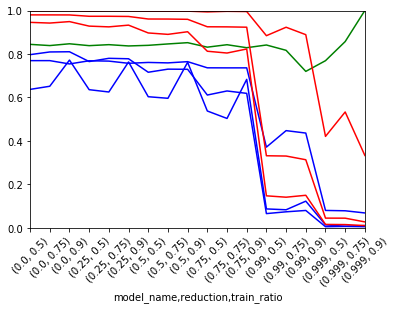

In [260]:
f1_scores = results[['f1-test', 'model_name', 'train_ratio', 'reduction']].groupby(['model_name', 'reduction','train_ratio']).agg(np.mean)

xticks = [str((x,y)) for x in [0.0, 0.25, 0.5, 0.75, 0.99, 0.999] for y in [0.5, 0.75, 0.9]]
colors = ['b']*len(unsupervised) + ['g']*len(semi_supervised) + ['r']*len(supervised)
fig, ax = plt.subplots()
for model, color in zip(unsupervised + semi_supervised + supervised, colors):
    f1_scores.loc[[model]].plot(ax=ax, legend=False, color=color)
    
_ = plt.xticks(range(len(xticks)),xticks, rotation=45)
_ = plt.ylim(0, 1)

In [247]:
def compute_lip(model, training_ratio, lipschitz):
    test_f1 = results[results.model_name.str.contains(model)].groupby(['reduction', 'train_ratio']).agg(np.mean)['f1-test'].loc[:,training_ratio].values
    final_results = []
    for i in range(len(test_f1)):
        elem_i = test_f1[i]
        for j in range(i+1, len(test_f1)):
            elem_j = test_f1[j]
            if(lipschitz):
                lipschitz_cte_estimator = (abs(elem_j-elem_i)/abs(j-i))
                final_results.append((j-i, lipschitz_cte_estimator))
            else:
                final_results.append(((j-i), (elem_j-elem_i)**2))
    final_results.sort(key=lambda tup: tup[0])  # sorts in place
    return final_results, np.mean([x[1] for x in final_results])

def plot_distance_performance(model, training_ratio, lipschitz, ax, marker):
    l = compute_lip(model, training_ratio, lipschitz)[0]
    d = defaultdict(list)
    distance_performance = []
    for key, value in l:
        d[key].append(value)

    for key in d:
        distance_performance.append((key, np.mean(d[key])))

    ax.scatter(*zip(*distance_performance), label=model, marker=marker, s=50, alpha=0.8)

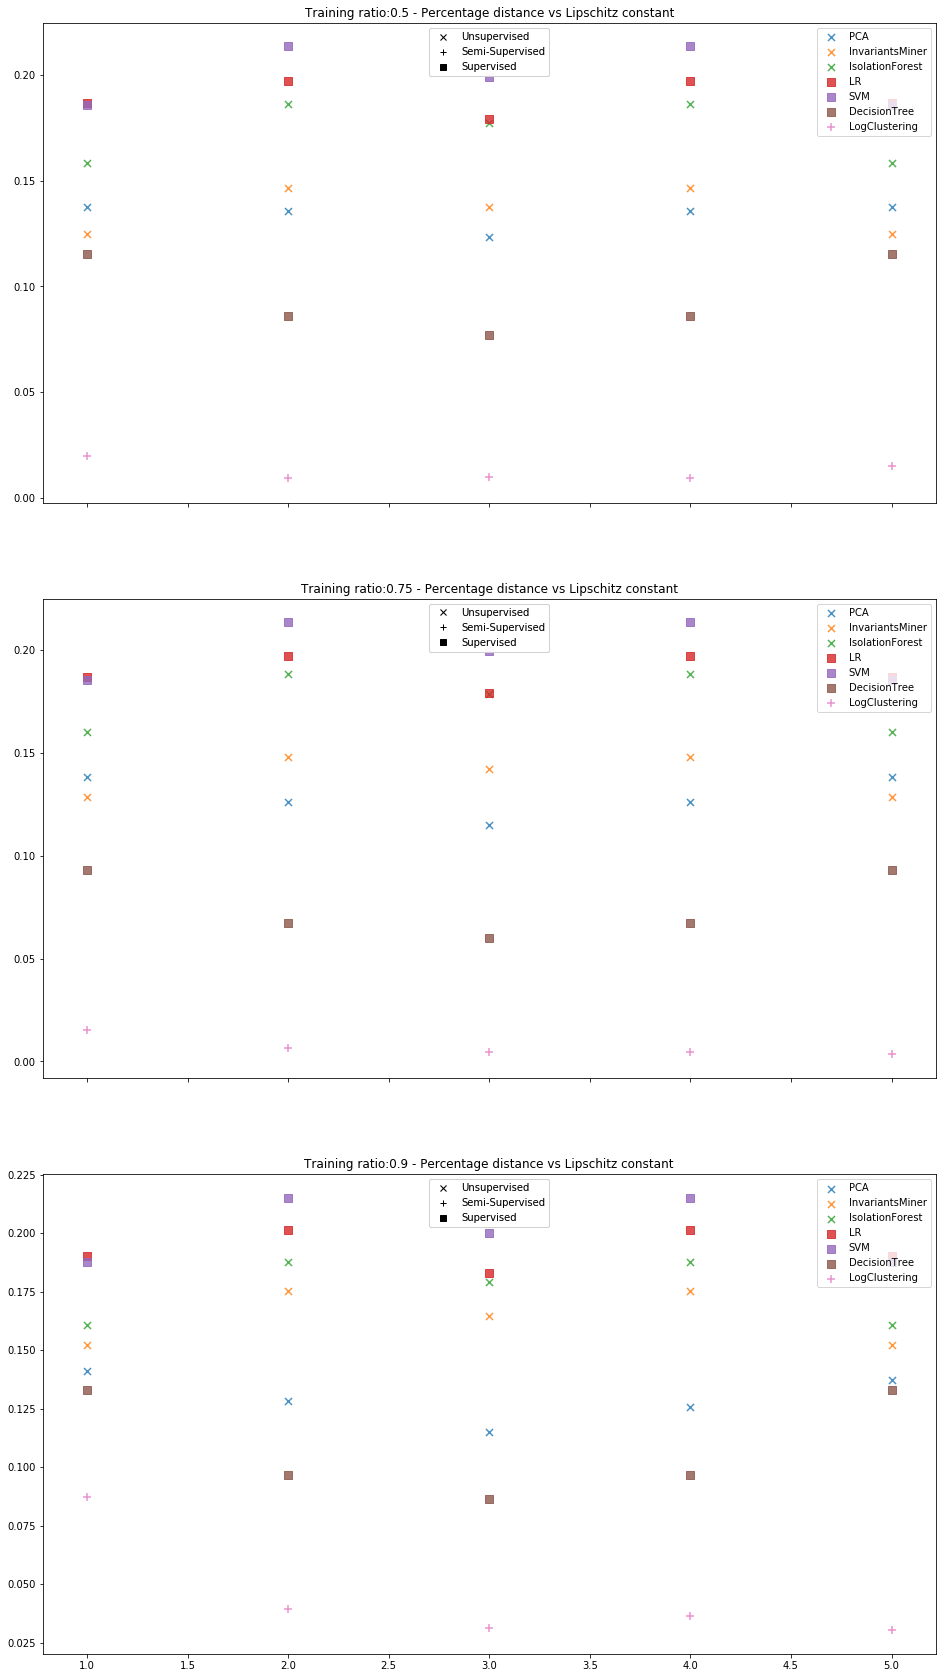

In [249]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(16, 30))

lipschitz = True
training_ratios = [0.5, 0.75, 0.9]
lipschitz_per_model = []

for ax, training_ratio in zip([ax1, ax2, ax3], training_ratios):
    for model in unsupervised + supervised + semi_supervised:
        lipschitz_per_model.append((model, training_ratio, compute_lip(model, training_ratio, lipschitz)[1]))
        
        if(model in unsupervised_models):
            plot_distance_performance(model, training_ratio, lipschitz, ax, 'x')
        elif(model in supervised_models):
            plot_distance_performance(model, training_ratio,lipschitz, ax, 's')
        else:
            plot_distance_performance(model, training_ratio, lipschitz, ax, '+')

    if(lipschitz):
        ax.set_title('Training ratio:'+ str(training_ratio) + ' - Percentage distance vs Lipschitz constant')
    else:
        ax.set_title('Training ratio:'+ str(training_ratio) + '- Percentage distance vs Difference Performance Squared')
    legend1 = ax.legend(loc=1)
    legend_elements = [Line2D([], [], marker='x', color='black', linestyle='None', label='Unsupervised'),
                       Line2D([], [], marker='+', color='black', linestyle='None', label='Semi-Supervised'),
                       Line2D([], [], marker='s',color='black', linestyle='None', label='Supervised')]
    
    legend2 = ax.legend(handles=legend_elements, loc=9) 
    ax.add_artist(legend1)
    ax.add_artist(legend2)

**Overall Ranking**

In [259]:
pd.DataFrame(lipschitz_per_model).groupby(0).agg(np.mean)[2].sort_values(ascending=True)

0
LogClustering      0.024873
DecisionTree       0.093811
PCA                0.131013
InvariantsMiner    0.146302
IsolationForest    0.174642
LR                 0.190742
SVM                0.200110
Name: 2, dtype: float64

**Observations:** 
- Train scores are fixed by train ratio.
- Supervised methods "fall" harder than other methods.
- LogClustering score goes up.

In [273]:
columns_test = list(filter(lambda x : 'test' in x and len(x)<8, results.columns))
results[results.model_name == 'LogClustering'].groupby(['reduction', 'train_ratio']).agg(np.mean)[columns_test]

f1-test  fn_test  fp_test  tn_test  tp_test
reduction train_ratio                                              
0.000     0.50         0.844338     2268        0   279112     6151
          0.75         0.838781     1169        0   139556     3041
          0.90         0.846970      447        0    55823     1237
0.250     0.50         0.838377     1757        0   279112     4557
          0.75         0.842954      857        0   139556     2300
          0.90         0.837017      354        0    55823      909
0.500     0.50         0.839857     1162        0   279112     3047
          0.75         0.846259      561        0   139556     1544
          0.90         0.852079      217        0    55823      625
0.750     0.50         0.831436      607        0   279112     1497
          0.75         0.842684      286        0   139556      766
          0.90         0.828929      123        0    55823      298
0.990     0.50         0.841379       23        0   279112       61
          0.75         0.816901       13        0   139556       29
          0.90         0.720000        7        0    55823        9
0.999     0.50         0.769231        3        0   279112        5
          0.75         0.857143        1        0   139556        3
          0.90         1.000000        0        0    55823        1

In [717]:
results = pd.concat(dfs)
results_grouped = results[results.reduction_train == 0.0].groupby(['model_name', 'reduction_train', 'reduction_test', 'train_ratio']).agg(np.mean)[['f1-test', 'f1-train']]
results_grouped.loc['DecisionTree']

In [718]:
def pick(results, train_ratio=None, reduction_train=None, reduction_test=None, model=None):
    tmp = results
    if(train_ratio != None):
        tmp = tmp[(tmp.index.get_level_values('train_ratio') == train_ratio)]
    if(reduction_train != None):
        tmp = tmp[(tmp.index.get_level_values('reduction_train') == reduction_train)]
    if(reduction_test != None):
        tmp = tmp[(tmp.index.get_level_values('reduction_test') == reduction_test)]
    if(model != None):
        tmp = tmp.loc[model]
    return tmp

def compute_lip(model, results, lipschitz, train_ratio, reduction_train=None, reduction_test=None):
    #test_f1 = results[results.model.str.contains(model)].groupby(['reduction_train']).agg(np.mean)['f_score'].values
    test_f1 = pick(results, train_ratio=train_ratio, reduction_train=reduction_train,  reduction_test=reduction_test, model=model).values
    final_results = []
    for i in range(len(test_f1)):
        elem_i = test_f1[i]
        for j in range(i+1, len(test_f1)):
            elem_j = test_f1[j]
            if(lipschitz):
                lipschitz_cte_estimator = (abs(elem_j-elem_i)/abs(j-i))
                final_results.append((j-i, lipschitz_cte_estimator))
            else:
                final_results.append(((j-i), (elem_j-elem_i)**2))
    final_results.sort(key=lambda tup: tup[0])  # sorts in place
    return final_results, np.mean([x[1] for x in final_results])
    
def plot_distance_performance(model,l, ax, marker):
    d = defaultdict(list)
    distance_performance = []
    for key, value in l:
        d[key].append(value)

    for key in d:
        distance_performance.append((key, np.mean(d[key])))

    ax.scatter(*zip(*distance_performance), label=model, marker=marker, s=50, alpha=0.8)

In [719]:
reduction_train= 0
lipschitz = True
training_ratios = [0.5, 0.75, 0.9]
lipschitz_per_model = []

for training_ratio in training_ratios:
    for model in set(results.model_name):
        l, mean_lip = compute_lip(model, results_grouped, lipschitz, training_ratio, reduction_train)
        lipschitz_per_model.append((model, training_ratio, mean_lip))

In [720]:
deeplog = pd.read_csv('deeplog.csv', names=['train_ratio', 'reduction_test', 'f1-test'], header=0)
deeplog['model_name'] = 'DeepLog'

In [721]:
results_all = pd.concat([results, deeplog]).fillna(0)
results_all_grouped = results_all[results_all.reduction_train == 0.0].groupby(['model_name', 'reduction_train', 'reduction_test', 'train_ratio']).agg(np.mean)[['f1-test', 'f1-train']]

In [722]:
reduction_train= 0
lipschitz = True
training_ratios = [0.5, 0.75, 0.9]
lipschitz_per_model = []

for training_ratio in training_ratios:
    for model in set(results_all.model_name):
        l, mean_lip = compute_lip(model, results_all_grouped, lipschitz, training_ratio, reduction_train)
        lipschitz_per_model.append((model, training_ratio, mean_lip))

## Average constant

In [735]:
#Save dataframe to csv
results_all_grouped.to_csv('Robustness-HDFS.csv')

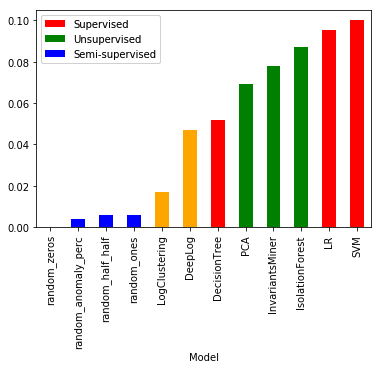

In [732]:
from matplotlib.patches import Patch
fig, ax = plt.subplots()

robustness_df = pd.DataFrame(lipschitz_per_model, columns=['Model', 'train_ratio', 'lipschitz'])
robustness_df_grouped = robustness_df.groupby(['Model']).agg(np.mean)['lipschitz'].sort_values()
random_models = set([x for x in results_all['model_name'] if('random' in x)])
color_code = ['r' if x in supervised_models else 'g' if (x in unsupervised_models) else 'b' if(x in random_models) else 'orange' for x  in robustness_df_grouped.index]
robustness_df_grouped.plot.bar(color=color_code)


legend_elements = [Patch(facecolor='r',label='Supervised'),
                   Patch(facecolor='g',label='Unsupervised'),
                   Patch(facecolor='b',label='Semi-supervised')]

legend = ax.legend(handles=legend_elements, loc=2)
ax.add_artist(legend)

## Average constant by train ratio

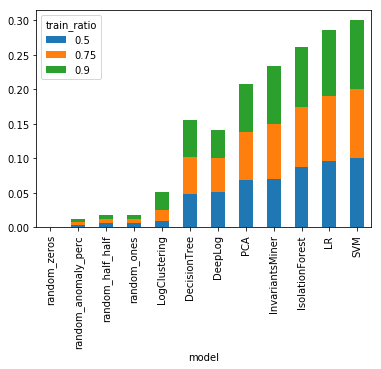

In [729]:
lip_df = pd.DataFrame(lipschitz_per_model, columns=['model', 'train_ratio', 'Lipschitz_constant'])
lip_df.pivot(index='model', columns='train_ratio', values='Lipschitz_constant').sort_values(by=0.5).plot(kind='bar', stacked=True)

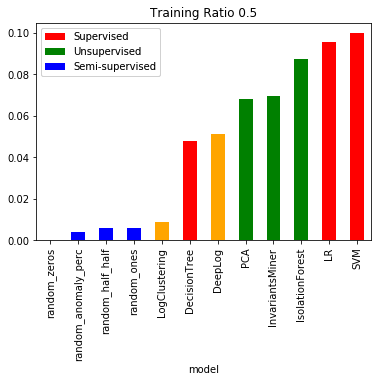

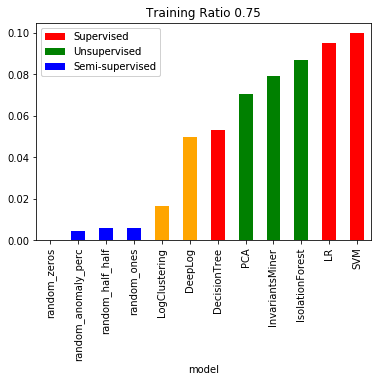

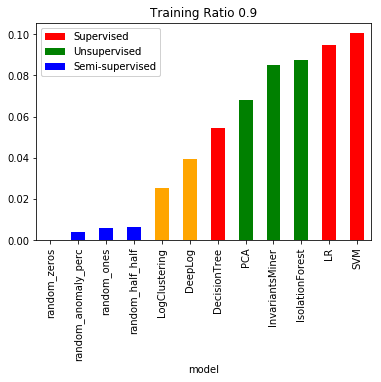

In [733]:
for train_ratio in [0.5, 0.75, 0.9]:
    fig, ax = plt.subplots()
    sorted_lip = lip_df[lip_df.train_ratio == train_ratio].set_index('model')['Lipschitz_constant'].sort_values()
    color_code = ['r' if x in supervised_models else 'g' if (x in unsupervised_models) else 'b' if(x in random_models) else 'orange' for x in sorted_lip.index]
    sorted_lip.plot.bar(color=color_code)
    plt.title('Training Ratio ' + str(train_ratio))
    
    legend_elements = [Patch(facecolor='r',label='Supervised'),
                       Patch(facecolor='g',label='Unsupervised'),
                       Patch(facecolor='b',label='Semi-supervised')]

    legend = ax.legend(handles=legend_elements, loc=2)
    ax.add_artist(legend)

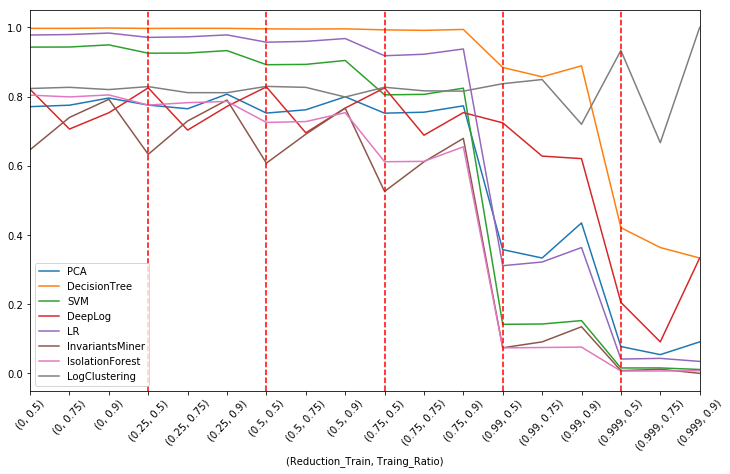

In [533]:
plt.figure(figsize=(12, 7))
xticks = [str((x,y)) for x in [0, 0.25, 0.5, 0.75, 0.99, 0.999] for y in [0.5, 0.75, 0.9]]
for model in set(results_all.model_name):
    results_all_grouped.loc[model]['f1-test'].plot()
    plt.xticks(range(len(xticks)), xticks, rotation=47)
plt.legend(set(results_all.model_name))
_ = plt.xlabel('(Reduction_Train, Traing_Ratio)')
for i in range(3, 16, 3):
    plt.axvline(i, color='red', linestyle='--')

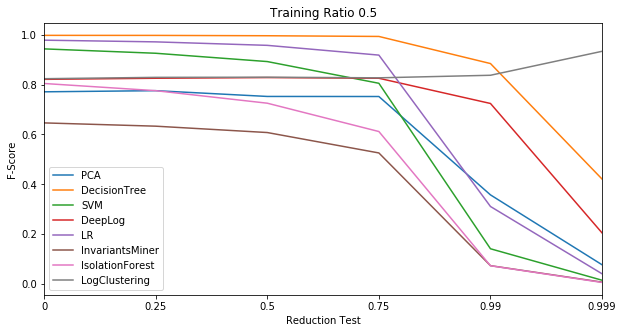

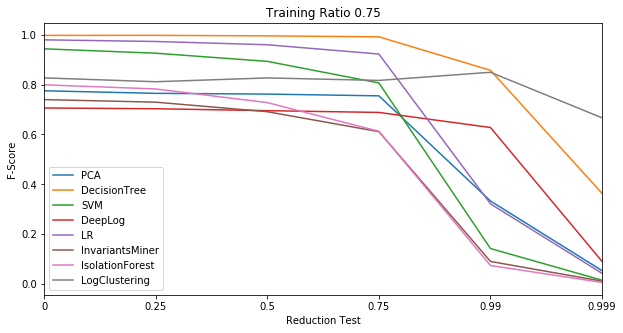

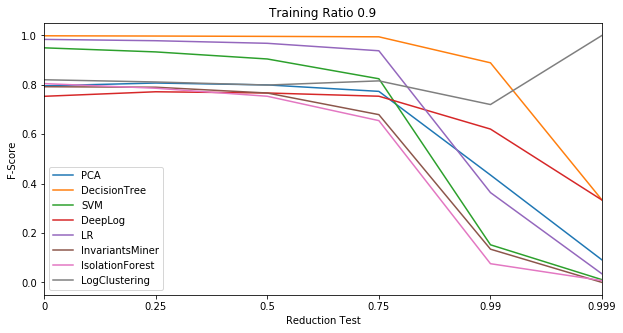

In [652]:
xticks = [str(x) for x in [0, 0.25, 0.5, 0.75, 0.99, 0.999]]
for train_ratio in [0.50, 0.75, 0.9]:
    plt.figure(figsize=(10,5))
    for model in set(results_all.model_name):
        results_all_grouped.loc[model,:,:,train_ratio]['f1-test'].plot()
        plt.xticks(range(len(xticks)), xticks)
        plt.title('Training Ratio '+ str(train_ratio))
        _, _ = plt.xlabel('Reduction Test'), plt.ylabel('F-Score')
        
    plt.legend(set(results_all.model_name))

In [655]:
f1_lipschitz = results_all.groupby(['model_name', 'train_ratio']).agg(np.mean)[['f1-test']]
f1_lipschitz['lipschitz'] = robustness_df.groupby(['Model', 'train_ratio']).agg(np.mean)['lipschitz']
f1_lipschitz.sort_values(['f1-test', 'lipschitz'], ascending=[False, True]).head()

,,f1-test,lipschitz,score
model_name,train_ratio,,,
LogClustering,0.50,0.853924,0.008868,-0.017923
DecisionTree,0.50,0.840997,0.047963,-0.101729
LogClustering,0.90,0.827703,0.025527,-0.052678
DecisionTree,0.90,0.827392,0.054537,-0.116771
LogClustering,0.75,0.799575,0.016275,-0.033227


In [653]:
f1_lipschitz['score'] = stats.hmean(f1_lipschitz[['f1-test', 'lipschitz']], axis=1)
f1_lipschitz.sort_values('score', ascending=True).head()

f1-test  lipschitz     score
model_name train_ratio                               
SVM        0.90         0.615792   0.100536 -0.240306
           0.50         0.594799   0.099903 -0.240139
           0.75         0.610968   0.099884 -0.238809
LR         0.75         0.485184   0.095171 -0.236790
           0.90         0.560911   0.094774 -0.228086

In [654]:
from scipy import stats
f1_lipschitz['score'] = 2*(f1_lipschitz['f1-test']*(-f1_lipschitz['lipschitz']))/(f1_lipschitz['f1-test']-f1_lipschitz['lipschitz'])
f1_lipschitz.sort_values('score', ascending=False).head()

f1-test  lipschitz     score
model_name    train_ratio                               
LogClustering 0.50         0.853924   0.008868 -0.017923
              0.75         0.799575   0.016275 -0.033227
              0.90         0.827703   0.025527 -0.052678
DeepLog       0.90         0.666577   0.039245 -0.083399
DecisionTree  0.50         0.840997   0.047963 -0.101729

In [ ]:
start = time.time()

supervised = ['LR', 'SVM', 'DecisionTree']
unsupervised = ['InvariantsMiner', 'PCA', 'IsolationForest']
semi_supervised = ['LogClustering']

#Load data
label_file = 'data/HDFS/anomaly_label.csv'
path = '../../../loglizer/HDFS_Data/'

#dfs = []
for train_ratio in [0.5, 0.75, 0.9]:
    for reduction_train in [0.0, 0.25, 0.5, 0.75, 0.99, 0.999]:
        print('Training ratio', train_ratio, '- Reduction percentage', reduction_train)
        #Load training data
        data_train = np.load(path + 'train/' + str(train_ratio) + '/'+ str(reduction_train) +'/HDFS_train_' + str(train_ratio) + '_' + str(reduction_train) +  '.npz', allow_pickle=True)
        x_tr, y_train = data_train['x_data'], data_train['y_data']


        for reduction_test in [0.0, 0.25, 0.5, 0.75, 0.99, 0.999]:
            print('Reduction percentage', reduction_test)

            #Load test data
            data_test = np.load(path + 'test/' + str(train_ratio) + '/'+ str(reduction_test) +'/HDFS_test_' + str(train_ratio) + '_' + str(reduction_test) + '.npz', allow_pickle=True)
            x_te, y_test = data_test['x_data'], data_test['y_data']

            print('Train accuracy:')
            anomaly_perc = sum(y_train)/len(y_train)
            y_pred_train = np.random.choice([0, 1], size=(len(y_train),), p=[1-anomaly_perc, anomaly_perc])
            y_pred_test = np.random.choice([0, 1], size=(len(y_test),), p=[1-anomaly_perc, anomaly_perc])
            
            precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_pred_train, average='binary')
            mcc_train = matthews_corrcoef(y_train, y_pred_train)
            roc_auc_train = roc_auc_score(y_train, y_pred_train)
            tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
            
            print('Test accuracy:')
            precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
            mcc_test = matthews_corrcoef(y_test, y_pred_test)
            roc_auc_test = roc_auc_score(y_test, y_pred_test)
            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

            
            results = [('model_name', 'random_anomaly_perc'), ('model', 'random_anomaly_perc'), 
                       ('f1-train', f1_train), ('f1-test', f1_test),
                       ('train_ratio', train_ratio),  ('reduction_train', reduction_train), 
                       ('reduction_test', reduction_test), 
                       ('precision_train', precision_train), ('precision_test', precision_test),
                       ('recall_train', recall_train),('recall_test', recall_test), 
                       ('mcc_train', mcc_train), ('mcc_test', mcc_test),
                       ('roc_auc_train', roc_auc_train), ('roc_auc_test', roc_auc_test),
                       ('tn_train', tn_train),('tn_test', tn_test), 
                       ('fp_train', fp_train), ('fp_test', fp_test), 
                       ('fn_train', fn_train), ('fn_test', fn_test),
                       ('tp_train', tp_train), ('tp_test', tp_test)]

            dfs.append(pd.DataFrame({x[0]:x[1:] for x in results}))

end = time.time()

print('It took:', end-start)

## Baselines

In [710]:
start = time.time()

#Load data
label_file = 'data/HDFS/anomaly_label.csv'
path = '../../../loglizer/HDFS_Data/'

#dfs = []
for train_ratio in [0.5, 0.75, 0.9]:
    for reduction_train in [0.0, 0.25, 0.5, 0.75, 0.99, 0.999]:
        print('Training ratio', train_ratio, '- Reduction percentage', reduction_train)
        #Load training data
        data_train = np.load(path + 'train/' + str(train_ratio) + '/'+ str(reduction_train) +'/HDFS_train_' + str(train_ratio) + '_' + str(reduction_train) +  '.npz', allow_pickle=True)
        x_tr, y_train = data_train['x_data'], data_train['y_data']]

        for reduction_test in [0.0, 0.25, 0.5, 0.75, 0.99, 0.999]:
            print('Reduction percentage', reduction_test)

            #Load test data
            data_test = np.load(path + 'test/' + str(train_ratio) + '/'+ str(reduction_test) +'/HDFS_test_' + str(train_ratio) + '_' + str(reduction_test) + '.npz', allow_pickle=True)
            x_te, y_test = data_test['x_data'], data_test['y_data']

            print('Train accuracy:')
            anomaly_perc = sum(y_train)/len(y_train)
            y_pred_train = np.random.choice([0, 1], size=(len(y_train),), p=[1-anomaly_perc, anomaly_perc])
            y_pred_test = np.random.choice([0, 1], size=(len(y_test),), p=[1-anomaly_perc, anomaly_perc])
            
            precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_pred_train, average='binary')
            mcc_train = matthews_corrcoef(y_train, y_pred_train)
            roc_auc_train = roc_auc_score(y_train, y_pred_train)
            tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
            
            print('Test accuracy:')
            precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
            mcc_test = matthews_corrcoef(y_test, y_pred_test)
            roc_auc_test = roc_auc_score(y_test, y_pred_test)
            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

            
            results = [('model_name', 'random_anomaly_perc'), ('model', 'random_anomaly_perc'), 
                       ('f1-train', f1_train), ('f1-test', f1_test),
                       ('train_ratio', train_ratio),  ('reduction_train', reduction_train), 
                       ('reduction_test', reduction_test), 
                       ('precision_train', precision_train), ('precision_test', precision_test),
                       ('recall_train', recall_train),('recall_test', recall_test), 
                       ('mcc_train', mcc_train), ('mcc_test', mcc_test),
                       ('roc_auc_train', roc_auc_train), ('roc_auc_test', roc_auc_test),
                       ('tn_train', tn_train),('tn_test', tn_test), 
                       ('fp_train', fp_train), ('fp_test', fp_test), 
                       ('fn_train', fn_train), ('fn_test', fn_test),
                       ('tp_train', tp_train), ('tp_test', tp_test)]

            dfs.append(pd.DataFrame({x[0]:x[1:] for x in results}))

end = time.time()

print('It took:', end-start)

Training ratio 0.5 - Reduction percentage 0.0
Reduction percentage 0.0
Train accuracy:
Test accuracy:
Reduction percentage 0.25
Train accuracy:
Test accuracy:
Reduction percentage 0.5
Train accuracy:
Test accuracy:
Reduction percentage 0.75
Train accuracy:
Test accuracy:
Reduction percentage 0.99
Train accuracy:
Test accuracy:
Reduction percentage 0.999
Train accuracy:
Test accuracy:
Training ratio 0.5 - Reduction percentage 0.25
Reduction percentage 0.0
Train accuracy:
Test accuracy:
Reduction percentage 0.25
Train accuracy:
Test accuracy:
Reduction percentage 0.5
Train accuracy:
Test accuracy:
Reduction percentage 0.75
Train accuracy:
Test accuracy:
Reduction percentage 0.99
Train accuracy:
Test accuracy:
Reduction percentage 0.999
Train accuracy:
Test accuracy:
Training ratio 0.5 - Reduction percentage 0.5
Reduction percentage 0.0
Train accuracy:
Test accuracy:
Reduction percentage 0.25
Train accuracy:
Test accuracy:
Reduction percentage 0.5
Train accuracy:
Test accuracy:
Reduction 

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy:
Test accuracy:
Reduction percentage 0.999
Train accuracy:
Test accuracy:
It took: 635.617330789566


In [714]:
import pickle
with open('dfs_with_random.pkl', 'wb') as _:
    pickle.dump(dfs, _)